# Libs

In [42]:
import numpy as np
import pandas as pd

In [43]:
from IPython.display import clear_output

In [44]:
import os

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
from tqdm import tqdm
tqdm.pandas()

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [48]:
from transformers import BertTokenizerFast as BertTokenizer, DistilBertModel, AdamW, get_linear_schedule_with_warmup

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [50]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [51]:
RANDOM_SEED = 42

In [52]:
import pytorch_lightning as pl
pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [53]:
TRAIN = 'data/train.csv'
TEST = 'data/test.csv'
TEST_LABEL = 'data/test_labels.csv'
SAMPLE = 'data/sample_submission.csv'
EPOCHS = 5
MAX_TOKEN_COUNT = 128
BATCH_SIZE = 32

# Data loading

In [54]:
df = pd.concat([chunk for chunk in tqdm(pd.read_csv(TRAIN, chunksize=1000), desc='Loading data')])
test_df = pd.read_csv(TEST)
test_label = pd.read_csv(TEST_LABEL)
sample_sub = pd.read_csv(SAMPLE)

Loading data: 160it [00:01, 121.91it/s]


# Data preprocessing

In [55]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [56]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# preparing for fitting

In [57]:
train_df, val_df = train_test_split(df, test_size=0.05)

In [58]:
LABEL_COLUMNS = df.columns.tolist()[2:]

In [59]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

In [60]:
class ToxicCommentsDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 128,
        test= False
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.test = test
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        _id = data_row['id']
        comment_text = data_row.comment_text
        
        if not self.test:
            labels = data_row[LABEL_COLUMNS]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True, # [CLS] & [SEP]
            return_token_type_ids=False,
            return_attention_mask=True, #attention_mask
            return_tensors='pt',
        )
        
        if not self.test:
            return dict(
            _id = _id,
            comment_text=comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )
        else:
            return dict(
                _id = _id,
                comment_text=comment_text,
                input_ids = encoding["input_ids"].flatten(),
                attention_mask=encoding["attention_mask"].flatten()
            )

In [61]:
BERT_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


In [62]:
# test=False
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

In [63]:
test_dataset = ToxicCommentsDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT,
  test=True
)

In [64]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# model

In [ ]:
class ToxicCommentTagger(nn.Module):
    
    def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)  # загрузка предобученной модели BERT
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)  # добавление линейного слоя
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        
        # Замораживаем все параметры BERT
        for param in list(self.bert.parameters())[:-2]:
            param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask=attention_mask)
        hidden_state = output.last_hidden_state[:, 0, :]
        output = self.classifier(hidden_state)
        output = torch.sigmoid(output)
        return output

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ToxicCommentTagger(len(LABEL_COLUMNS)).to(device)

768


In [67]:
steps_per_epoch=len(train_df) // BATCH_SIZE

In [68]:
total_training_steps = steps_per_epoch * EPOCHS
warmup_steps = total_training_steps // 5

In [89]:
for name, param in model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')


bert.embeddings.word_embeddings.weight: requires_grad=False
bert.embeddings.position_embeddings.weight: requires_grad=False
bert.embeddings.LayerNorm.weight: requires_grad=False
bert.embeddings.LayerNorm.bias: requires_grad=False
bert.transformer.layer.0.attention.q_lin.weight: requires_grad=False
bert.transformer.layer.0.attention.q_lin.bias: requires_grad=False
bert.transformer.layer.0.attention.k_lin.weight: requires_grad=False
bert.transformer.layer.0.attention.k_lin.bias: requires_grad=False
bert.transformer.layer.0.attention.v_lin.weight: requires_grad=False
bert.transformer.layer.0.attention.v_lin.bias: requires_grad=False
bert.transformer.layer.0.attention.out_lin.weight: requires_grad=False
bert.transformer.layer.0.attention.out_lin.bias: requires_grad=False
bert.transformer.layer.0.sa_layer_norm.weight: requires_grad=False
bert.transformer.layer.0.sa_layer_norm.bias: requires_grad=False
bert.transformer.layer.0.ffn.lin1.weight: requires_grad=False
bert.transformer.layer.0.ffn

In [69]:
criterion = nn.BCELoss()

optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

In [90]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  avg_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
    # push the batch to gpu
#     batch = [r.to(device) for r in batch]
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)     

    # clear previously calculated gradients 
    model.zero_grad()        
    outputs = model(input_ids, attention_mask)
    loss = criterion(outputs, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()
    scheduler.step()

    # model predictions are stored on GPU. So, push it to CPU
    outputs=outputs.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(outputs)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  print(f"{step}: {avg_loss}")
  

    
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [91]:
from sklearn.metrics import roc_auc_score
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  #t0 = time.time()
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  total_labels = []

  # iterate over batches
  for step,batch in enumerate(tqdm(val_dataloader, desc='Evaluating')):
    # push the batch to gpu

#     batch = [r.to(device) for r in batch]
    
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)   
    # deactivate autograd
    with torch.no_grad():
      
      outputs = model(input_ids, attention_mask)
      loss = criterion(outputs, labels)

      total_loss = total_loss + loss.item()

      outputs = outputs.detach().cpu().numpy()
      labels = labels.detach().cpu().numpy()
      total_preds.append(outputs)
      total_labels.append(labels)


  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  print(f"{step}: {avg_loss}")



  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_labels = np.concatenate(total_labels, axis=0)
  true = np.array(total_labels)
  pred = np.array(total_preds>0.5)
  #print(true)
  #print(pred)
  for i, name in enumerate(LABEL_COLUMNS):
      try:
          print(f"{name} roc_auc {roc_auc_score(true[:, i], pred[:, i])}")
      except Exception as e:
        print(e)
        pass
  print(f"Evaluate loss {total_loss / len(val_dataloader)}")
  return avg_loss, total_preds, total_labels

In [92]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]
EPOCHS = 3
#for each epoch
for epoch in range(EPOCHS):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
    
    #train model
    train_loss, _ = train()
    clear_output()
    #evaluate model
    valid_loss, _, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


Training Loss: 0.084
Validation Loss: 0.080


In [93]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs#[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [94]:
avg_loss, total_preds, total_labels = evaluate()


Evaluating...


Evaluating: 100%|██████████| 250/250 [00:23<00:00, 10.47it/s]

249: 0.08048856165260077
toxic roc_auc 0.6727135543119828
severe_toxic roc_auc 0.5
obscene roc_auc 0.6387564041562354
threat roc_auc 0.5
insult roc_auc 0.6101168437368083
identity_hate roc_auc 0.5
Evaluate loss 0.08048856165260077


label: toxic
AUC: 0.6727
Accuracy: 93.47%


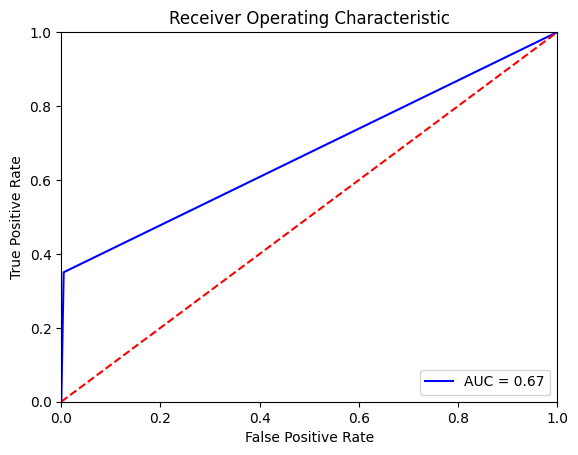

label: severe_toxic
AUC: 0.5000
Accuracy: 99.00%


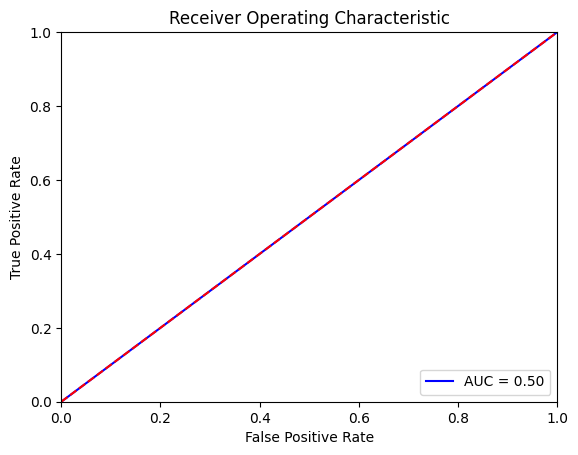

label: obscene
AUC: 0.6388
Accuracy: 96.15%


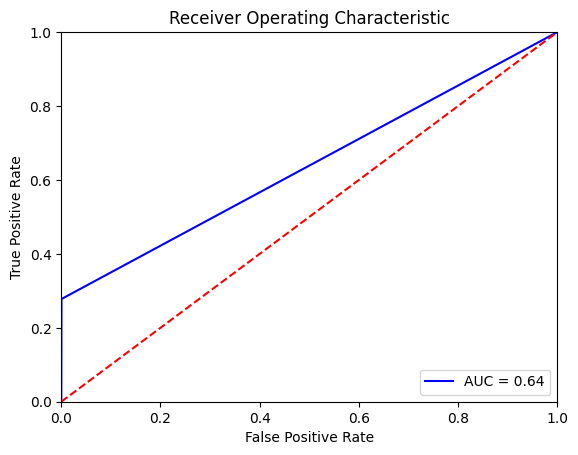

label: threat
AUC: 0.5000
Accuracy: 99.84%


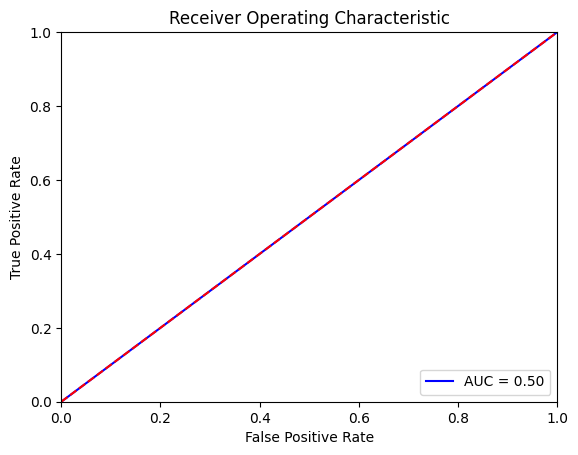

label: insult
AUC: 0.6101
Accuracy: 95.84%


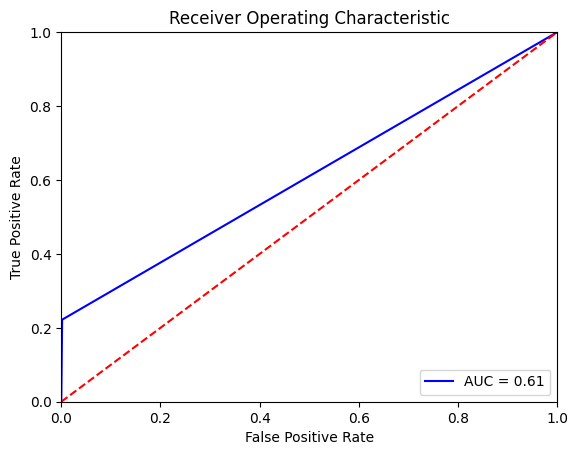

label: identity_hate
AUC: 0.5000
Accuracy: 99.11%


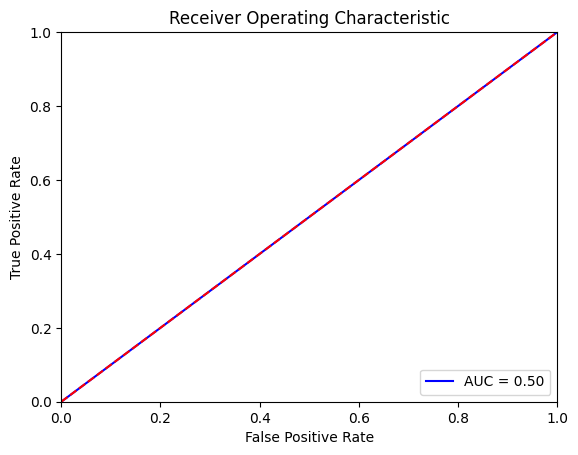

In [95]:
for i, name in enumerate(LABEL_COLUMNS):
    print(f"label: {name}")
    evaluate_roc(total_preds[:,i]>0.5, total_labels[:,i])

# Inference

In [96]:
def test():
  
  print("\nTesting...")
  #t0 = time.time()
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  _ids = []

  # iterate over batches
  for step, batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu

#     batch = [r.to(device) for r in batch]
    _id = batch["_id"]
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    #labels = batch["labels"].to(device)   
    # deactivate autograd
    with torch.no_grad():
      
        outputs = model(input_ids, attention_mask)
        outputs = outputs#.detach().cpu().numpy()
        _ids.append(_id)
        total_preds.append(outputs)
    
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
#   _ids  = torch.cat(_ids, axis=0)
  _ids = np.concatenate(_ids, axis=0)
  total_preds  = torch.cat(total_preds, axis=0)
  results = dict(id=_ids,
      predictions = total_preds
      )
    

  return avg_loss, total_preds, results

In [97]:
avg_test_loss, total_test_preds, sub = test()


Testing...
  Batch    50  of  4,787.
  Batch   100  of  4,787.
  Batch   150  of  4,787.
  Batch   200  of  4,787.
  Batch   250  of  4,787.
  Batch   300  of  4,787.
  Batch   350  of  4,787.
  Batch   400  of  4,787.
  Batch   450  of  4,787.
  Batch   500  of  4,787.
  Batch   550  of  4,787.
  Batch   600  of  4,787.
  Batch   650  of  4,787.
  Batch   700  of  4,787.
  Batch   750  of  4,787.
  Batch   800  of  4,787.
  Batch   850  of  4,787.
  Batch   900  of  4,787.
  Batch   950  of  4,787.
  Batch 1,000  of  4,787.
  Batch 1,050  of  4,787.
  Batch 1,100  of  4,787.
  Batch 1,150  of  4,787.
  Batch 1,200  of  4,787.
  Batch 1,250  of  4,787.
  Batch 1,300  of  4,787.
  Batch 1,350  of  4,787.
  Batch 1,400  of  4,787.
  Batch 1,450  of  4,787.
  Batch 1,500  of  4,787.
  Batch 1,550  of  4,787.
  Batch 1,600  of  4,787.
  Batch 1,650  of  4,787.
  Batch 1,700  of  4,787.
  Batch 1,750  of  4,787.
  Batch 1,800  of  4,787.
  Batch 1,850  of  4,787.
  Batch 1,900  of  4,787.


In [98]:
D = pd.DataFrame()
D['id'] = sub['id']
D

,id
0,00001cee341fdb12
1,0000247867823ef7
2,00013b17ad220c46
3,00017563c3f7919a
4,00017695ad8997eb
...,...
153159,fffcd0960ee309b5
153160,fffd7a9a6eb32c16
153161,fffda9e8d6fafa9e
153162,fffe8f1340a79fc2


In [99]:
D[LABEL_COLUMNS] = (sub['predictions'].cpu().numpy())
D

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.891778,0.108117,0.759496,0.006296,0.679856,0.043982
1,0000247867823ef7,0.031044,0.004727,0.020502,0.001725,0.015967,0.004070
2,00013b17ad220c46,0.040406,0.009648,0.031804,0.006032,0.025168,0.011107
3,00017563c3f7919a,0.005710,0.001010,0.002897,0.000712,0.002794,0.001117
4,00017695ad8997eb,0.053116,0.005173,0.026459,0.002252,0.020220,0.005022
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.235816,0.018187,0.133207,0.004780,0.108159,0.014297
153160,fffd7a9a6eb32c16,0.095445,0.009677,0.055952,0.003247,0.047348,0.010413
153161,fffda9e8d6fafa9e,0.010831,0.002306,0.007913,0.001380,0.006451,0.003529
153162,fffe8f1340a79fc2,0.017395,0.002784,0.008966,0.001607,0.008006,0.004338


In [100]:
D.to_csv("submission.csv", index=False)
